# Calibrating the velocity field against observations 

In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median
import corner
from getdist import plots
from scipy.stats import multivariate_normal

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

## LOS density & radial velocity plots 

In [ ]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

In [ ]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [23]:
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_mock_CB2_17417_large.hdf5"

simname = "csiborg2_main"
catalogue = "CB2_large"
loader = csiborgtools.flow.DataLoader(simname, 10, catalogue, fpath_data, paths, ksmooth=1)
get_model_kwargs = {"zcmb_max": 0.07}

23:08:02: reading the catalogue.
23:08:02: reading the interpolated field.
23:08:02: calculating the radial velocity.


/mnt/users/rstiskalek/csiborgtools/csiborgtools/flow/flow_model.py:113: UserWarning: The number of radial steps is even. Skipping the first step at 0.0 because Simpson's rule requires an odd number of steps.
  warn(f"The number of radial steps is even. Skipping the first "


#### Running HMC

In [24]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)
model_kwargs = {"sample_alpha": True, "sample_beta": True, "sample_h": False}

Selected 1000/1000 galaxies.


In [25]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=500)

rng_key = jax.random.PRNGKey(5)

In [26]:
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 750/750 [01:21<00:00,  9.25it/s, 7 steps of size 6.38e-01. acc. prob=0.89] 


In [27]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
# print(csiborgtools.numpyro_gof(model, mcmc, model_kwargs))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    Vext_x     29.99     14.24     29.16      7.24     51.12    668.45      1.00
    Vext_y      2.46     14.55      1.93    -21.38     26.45    564.90      1.00
    Vext_z     44.35     14.36     43.95     21.69     67.45    680.67      1.00
     alpha      0.89      0.06      0.89      0.81      0.99    623.96      1.00
      beta      0.95      0.04      0.95      0.89      1.02    596.95      1.00
   sigma_v     74.53      8.92     74.32     61.13     90.91    684.07      1.00

Number of divergences: 0


In [28]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
if "beta" in samples:
    print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

|V|  = 57.178871154785156 +- 14.913084983825684
l    = 118.64846126054445 +- 16.786467620956774
b    = -6.3910210700885655 +- 14.028581337650568
beta = 0.9534719586372375 +- 0.04203781858086586


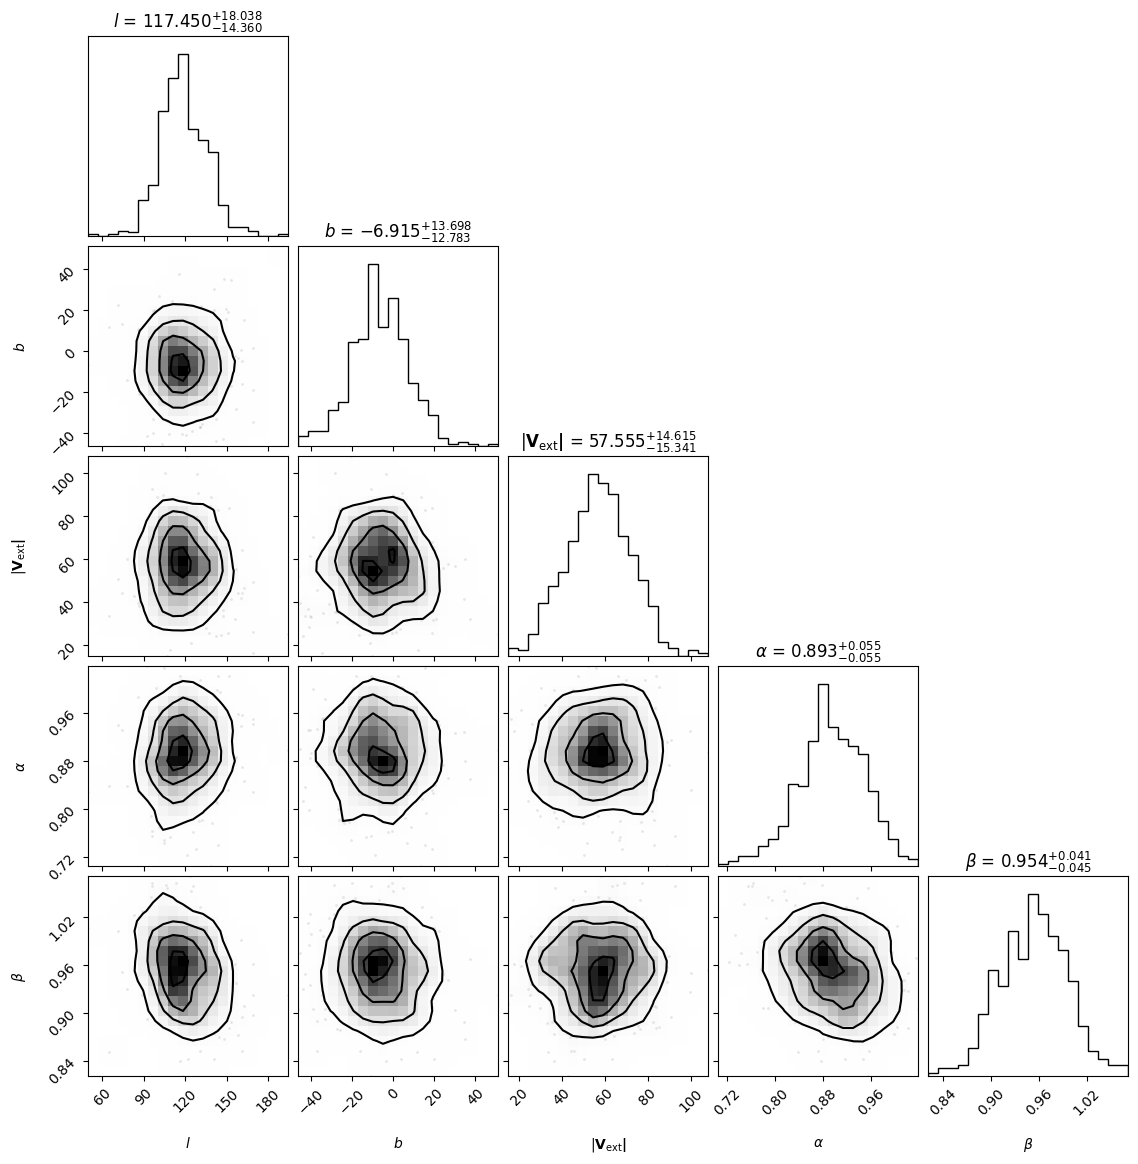

In [29]:
data = [l, b, Vmag]
labels = [r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
if "alpha" in samples:
    data.append(samples["alpha"])
    labels.append(r"$\alpha$")

if "beta" in samples:
    data.append(samples["beta"])
    labels.append(r"$\beta$")

if "h" in samples:
    data.append(samples["h"])
    labels.append(r"$h$")

data = np.vstack(data).T
fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)
fig.savefig(f"../plots/mock_{simname}_{catalogue}.png", dpi=500, bbox_inches="tight")

## Vizualize the results

####  Functions to read in the results


Reading SFI_groups fitted to Carrick2015 with ksmooth = 0.


BIC  = 8896.874023 +- 0.000000
AIC  = 8866.249023 +- 0.000000
logZ = -4417.928711 +- 0.000000
chi2 = 0.000000 +- 0.000000


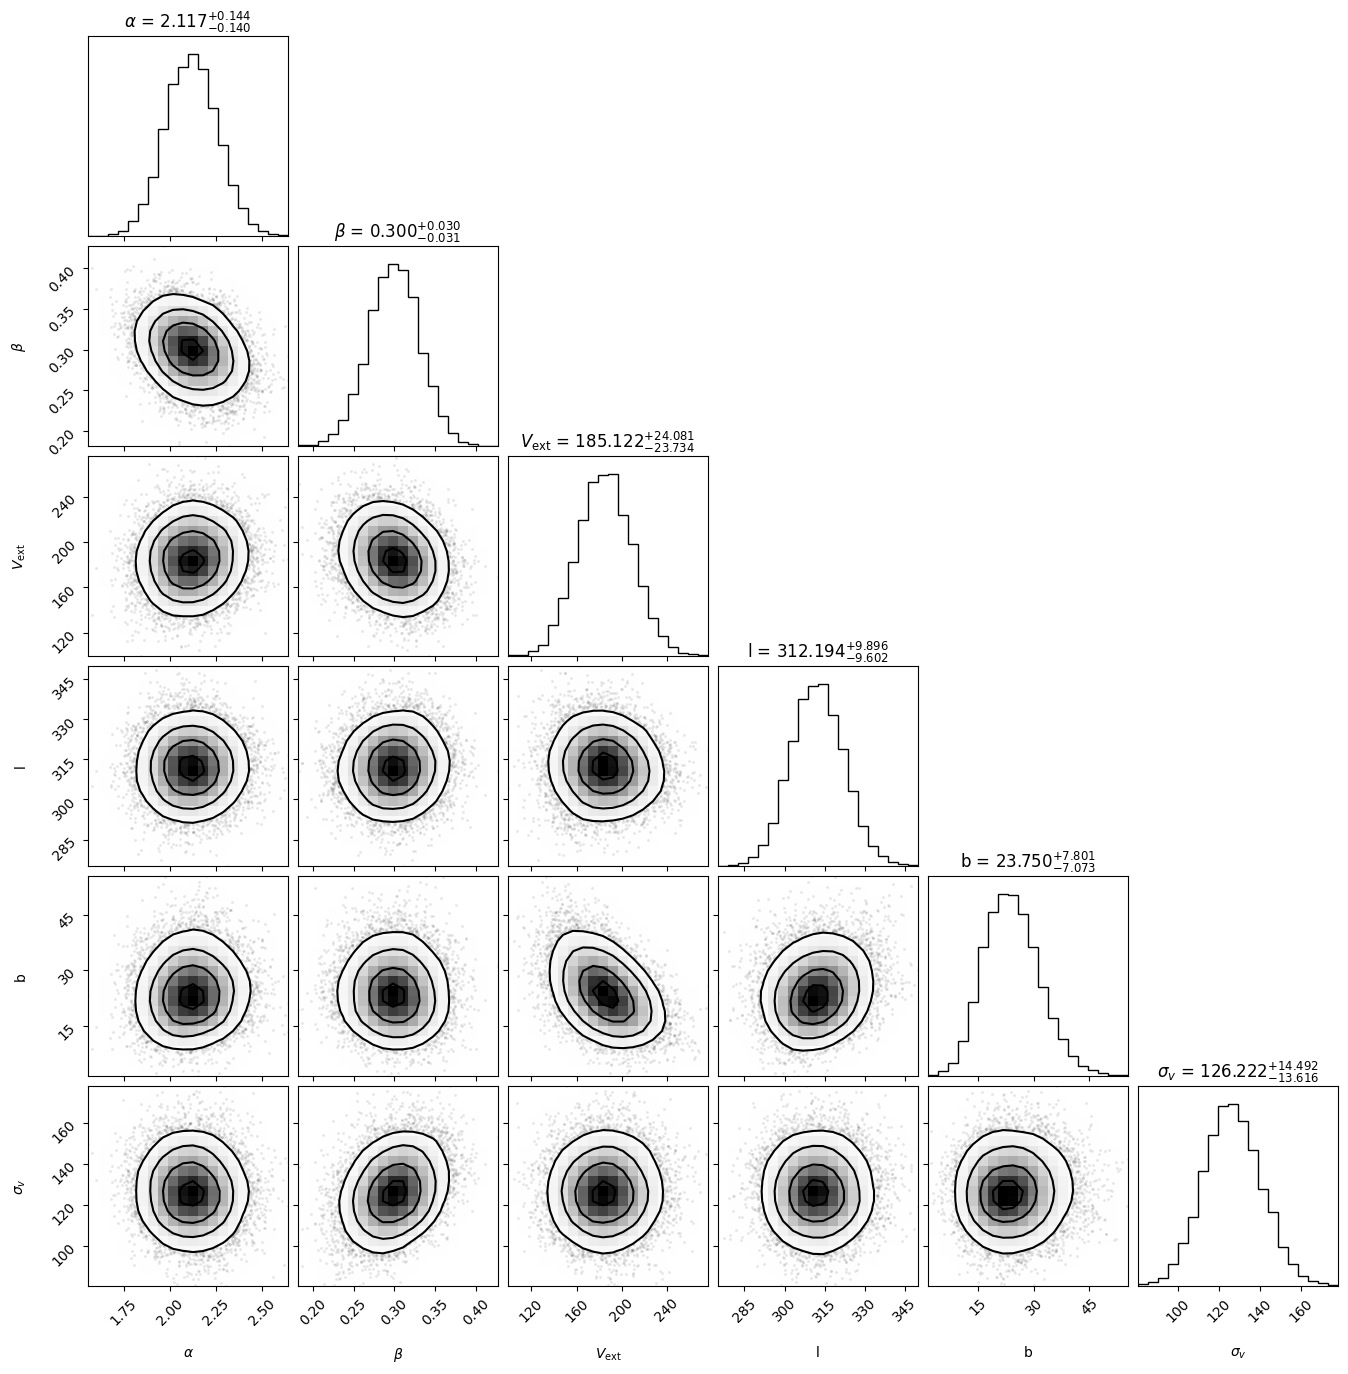

In [55]:
data, names, gof = read_samples("SFI_groups", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [ ]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
     LOSS_Carrick_0,
     # LOSS_Carrick_1,
     # LOSS_CB1_0,
     LOSS_CB1_1,
     LOSS_CB2_0,
     LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [ ]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    # FOUNDATION_CB1_0,
    FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### PantheonPlus-only comparison

In [58]:
# PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
# PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

# PANTHEONP_CB1_0 = read_samples("Pantheon+", "csiborg1", 0, return_MCsamples=True)
# PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)

# STILL RUNNING
PANTHEONP_CB2_0 = read_samples("Pantheon+", "csiborg2_main", 0, return_MCsamples=True)
PANTHEONP_CB2_1 = read_samples("Pantheon+", "csiborg2_main", 1, return_MCsamples=True)



Reading Pantheon+ fitted to csiborg2_main with ksmooth = 0.


BIC  = 10056.015674 +- 27.407189
AIC  = 10010.824268 +- 27.407189
logZ = -5006.756958 +- 48.432771
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading Pantheon+ fitted to csiborg2_main with ksmooth = 1.
BIC  = 10027.133105 +- 13.850270
AIC  = 9981.941699 +- 13.850270
logZ = -4981.690186 +- 6.885272
chi2 = 0.000000 +- 0.000000
Removed no burn in


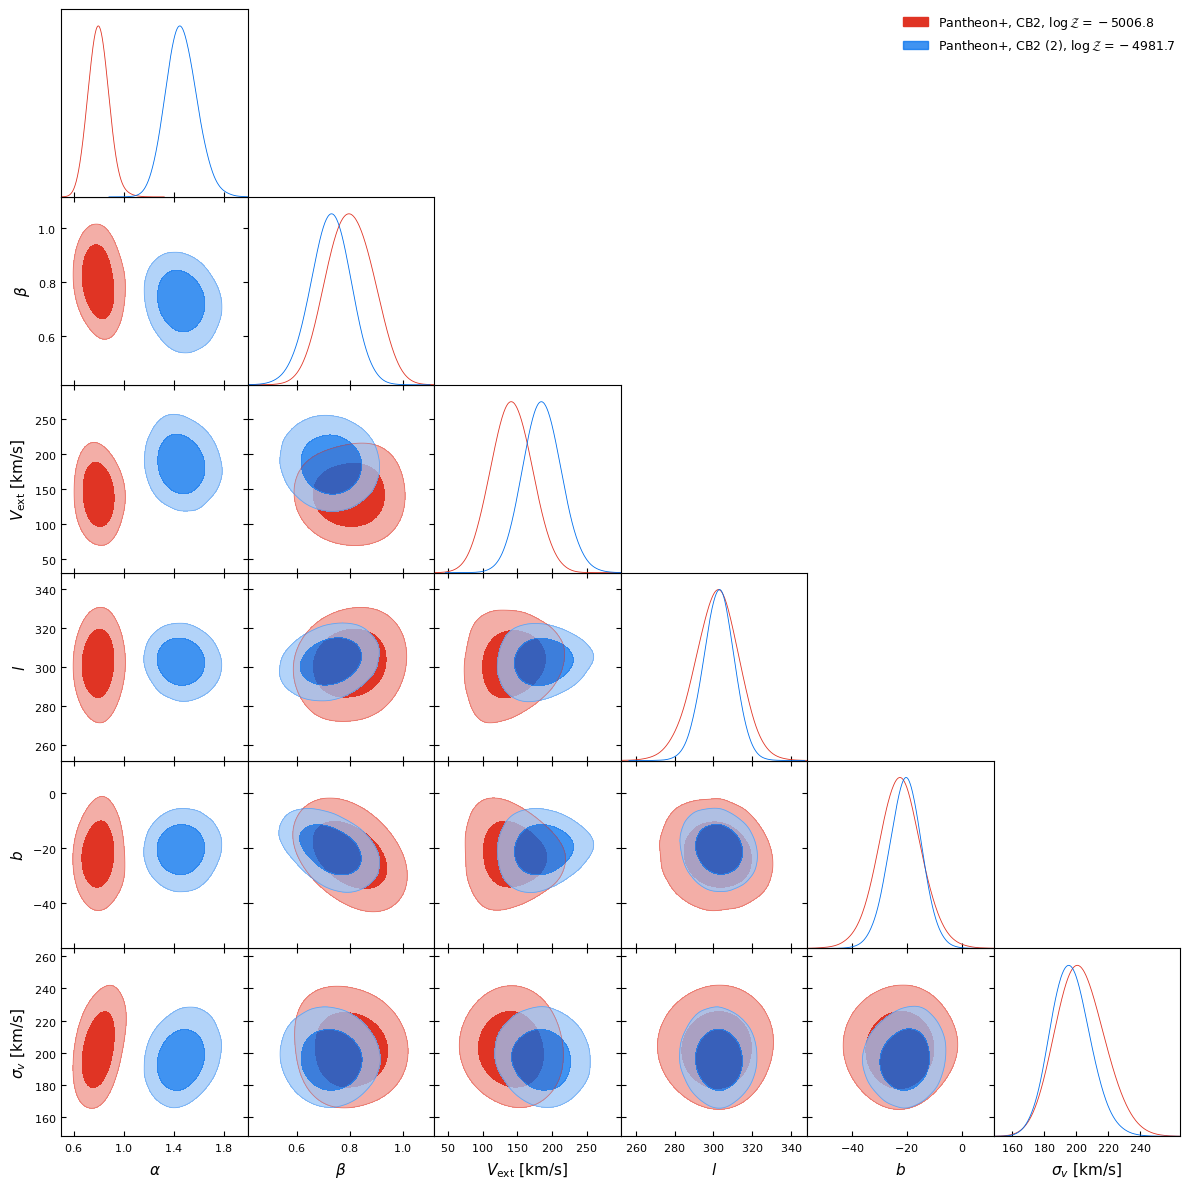

In [59]:
X = [
    # PANTHEONP_Carrick_0,
    # PANTHEONP_Carrick_1,
    # PANTHEONP_CB1_0,
    # PANTHEONP_CB1_1,
    PANTHEONP_CB2_0,
    PANTHEONP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/PANTHEONP_comparison.png", dpi=500,)

### 2MTF comparison

In [ ]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB1_0 = read_samples("2MTF", "csiborg1", 0, return_MCsamples=True)
TWOMTF_CB1_1 = read_samples("2MTF", "csiborg1", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


In [ ]:
X = [
    TWOMTF_Carrick_0,
    # TWOMTF_Carrick_1,
    # TWOMTF_CB1_0,
    TWOMTF_CB1_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/2MTF_comparison.png", dpi=500,)

### SFI galaxies

In [ ]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

# SFIGAL_CB1_0 = read_samples("SFI_gals", "csiborg1", 0, return_MCsamples=True)
# SFIGAL_CB1_1 = read_samples("SFI_gals", "csiborg1", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)

In [ ]:
X = [
    SFIGAL_Carrick_0,
    # SFIGAL_Carrick_1,
    # SFIGAL_CB1_0,
    # SFIGAL_CB1_1,
    # SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### SFI groups

In [60]:
SFIGROUP_Carrick_0 = read_samples("SFI_groups", "Carrick2015", 0, return_MCsamples=True)
SFIGROUP_Carrick_1 = read_samples("SFI_groups", "Carrick2015", 1, return_MCsamples=True)

SFIGROUP_CB2_0 = read_samples("SFI_groups", "csiborg2_main", 0, return_MCsamples=True)
SFIGROUP_CB2_1 = read_samples("SFI_groups", "csiborg2_main", 1, return_MCsamples=True)


Reading SFI_groups fitted to Carrick2015 with ksmooth = 0.
BIC  = 8896.874023 +- 0.000000
AIC  = 8866.249023 +- 0.000000
logZ = -4417.928711 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_groups fitted to Carrick2015 with ksmooth = 1.
BIC  = 8957.607422 +- 0.000000
AIC  = 8926.982422 +- 0.000000
logZ = -4447.800293 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_groups fitted to csiborg2_main with ksmooth = 0.
BIC  = 8782.843457 +- 17.080250
AIC  = 8752.218457 +- 17.080250
logZ = -4362.511084 +- 8.475959
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_groups fitted to csiborg2_main with ksmooth = 1.
BIC  = 8726.997656 +- 21.534941
AIC  = 8696.372656 +- 21.534941
logZ = -4333.264429 +- 10.550374
chi2 = 0.000000 +- 0.000000
Removed no burn in


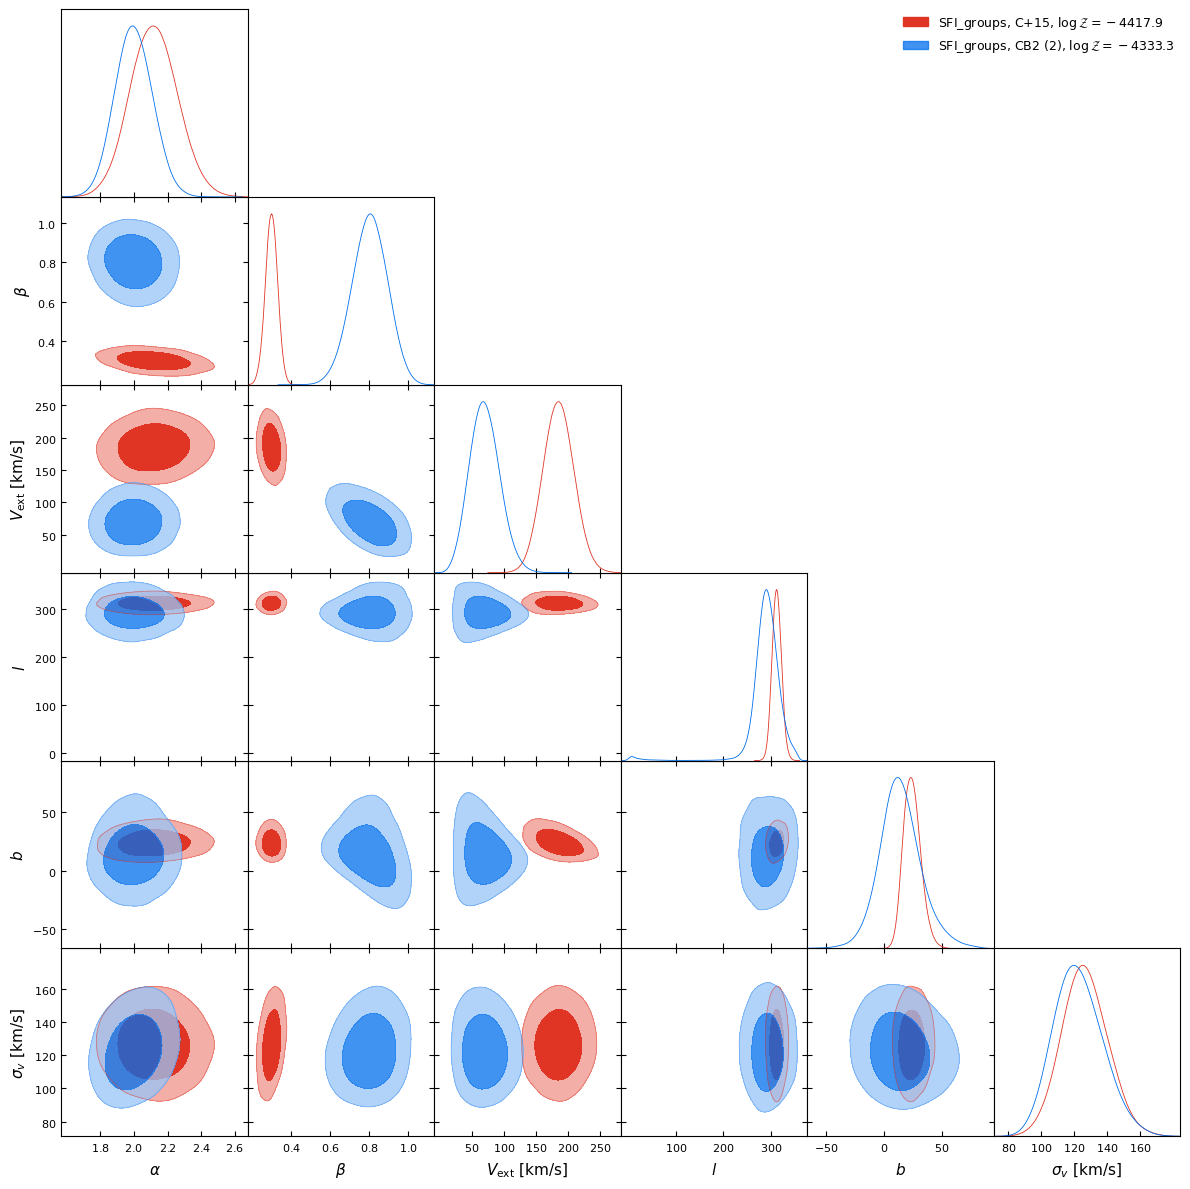

In [63]:
X = [
    SFIGROUP_Carrick_0,
    # SFIGROUP_Carrick_1,
    # SFIGROUP_CB2_0,
    SFIGROUP_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/SFI_gals_comparison.png", dpi=500,)

### Mock CB2

In [119]:
SMALLMOCK_CB2_0 = read_samples("CB2_small", "csiborg2_main", 0, return_MCsamples=True)
SMALLMOCK_CB2_1 = read_samples("CB2_small", "csiborg2_main", 1, return_MCsamples=True)


Reading CB2_small fitted to csiborg2_main with ksmooth = 0.
BIC  = 1518.694963 +- 15.561768
AIC  = 1503.063981 +- 15.561768
logZ = -729.645736 +- 6.980612
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading CB2_small fitted to csiborg2_main with ksmooth = 1.
BIC  = 1518.014282 +- 8.280079
AIC  = 1502.383301 +- 8.280079
logZ = -729.024292 +- 3.814355
chi2 = 0.000000 +- 0.000000
Removed no burn in


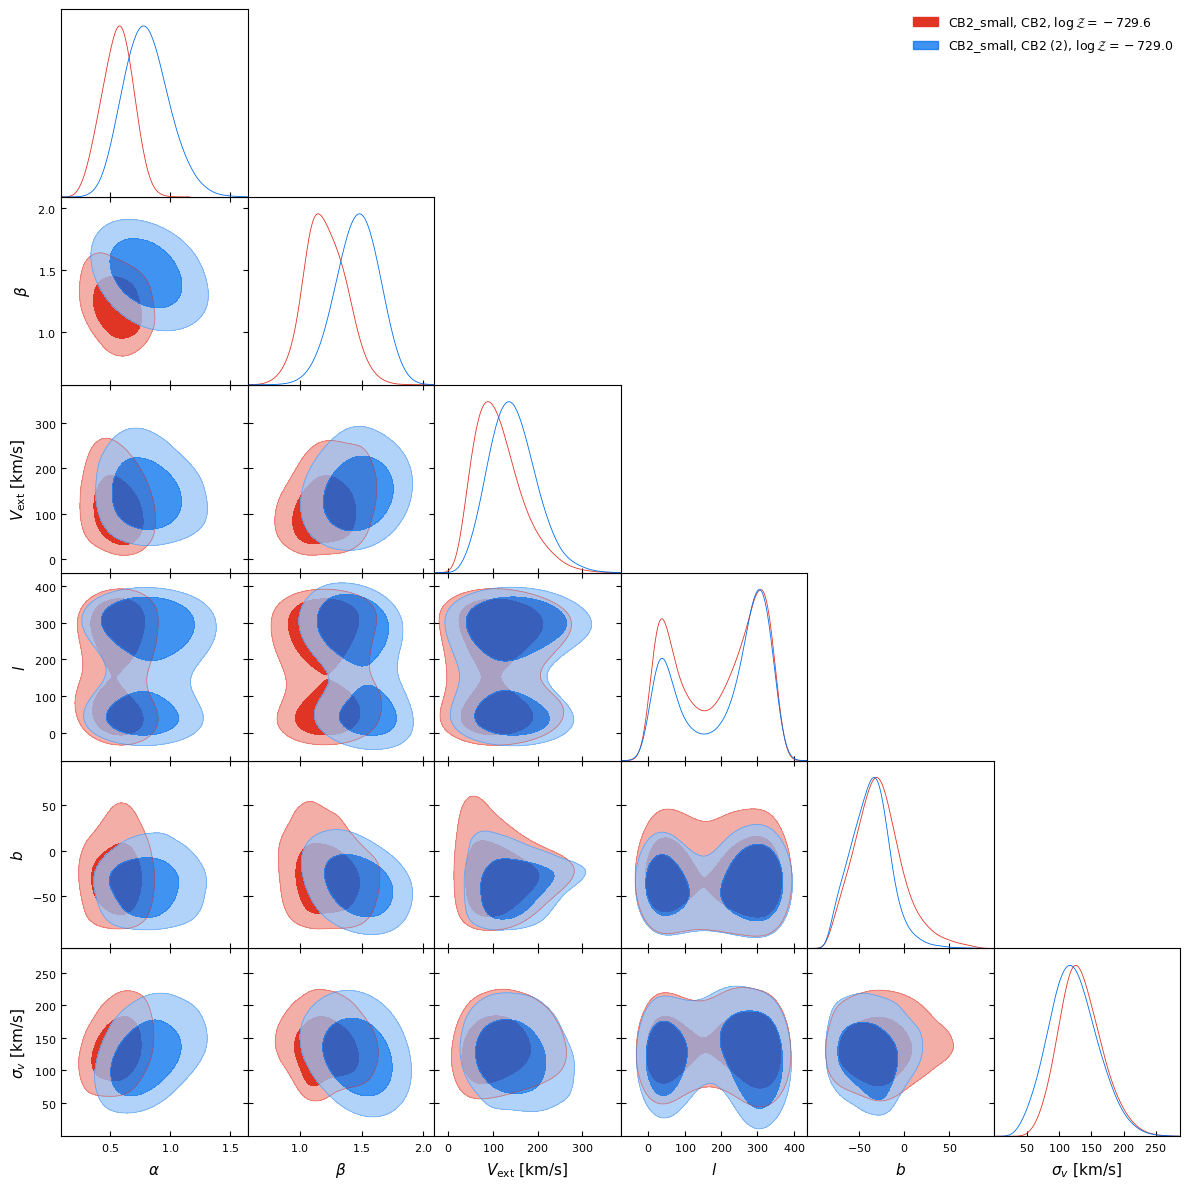

In [121]:
X = [
    SMALLMOCK_CB2_0,
    SMALLMOCK_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
# g.export(f"../plots/CB2_mocks.png", dpi=500,)

### External flow consistency

#### Carrick2015

In [ ]:
X = [
    # LOSS_Carrick_0,
    # FOUNDATION_Carrick_0,
    PANTHEONP_Carrick_0,
    TWOMTF_Carrick_0,
    SFIGAL_Carrick_0,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/Carrick2015_external_flow.png", dpi=500,)

#### CSiBORG1

In [ ]:
X = [
    # LOSS_CB1_1,
    # FOUNDATION_CB1_1,
    PANTHEONP_CB1_1,
    TWOMTF_CB1_1,
    # SFIGAL_CB1_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB1_external_flow.png", dpi=500,)

#### CSiBORG2

In [ ]:
X = [
    # LOSS_CB2_1,
    # FOUNDATION_CB2_1,
    PANTHEONP_CB2_1,
    TWOMTF_CB2_1,
    SFIGAL_CB2_1,
    ]

params = ["Vmag", "l", "b", "beta"]
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right',)
g.export(f"../plots/CB2_external_flow.png", dpi=500,)

In [67]:
k = 1
LG = 0

# Carrick
# LOSS_Carrick_LG = read_samples("LOSS", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_Carrick_LG = read_samples("Foundation", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_Carrick_LG = read_samples("Pantheon+", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_Carrick_LG = read_samples("2MTF", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_Carrick_LG = read_samples("SFI_gals", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUPS_Carrick_LG = read_samples("SFI_groups", "Carrick2015", k, return_MCsamples=True, subtract_LG_velocity=LG)


# # CSiBORG2
# LOSS_CB2_LG = read_samples("LOSS", "csiborg2_main", k, return_MCsamples=True,subtract_LG_velocity=LG)
# FOUNDATION_CB2_LG = read_samples("Foundation", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB2_LG = read_samples("Pantheon+", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB2_LG = read_samples("2MTF", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGAL_CB2_LG = read_samples("SFI_gals", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)
SFIGROUP_CB2_LG = read_samples("SFI_groups", "csiborg2_main", k, return_MCsamples=True, subtract_LG_velocity=LG)

# # CSiBORG1
# LOSS_CB1_LG = read_samples("LOSS", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# FOUNDATION_CB1_LG = read_samples("Foundation", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# PANTHEON_CB1_LG = read_samples("Pantheon+", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# TWOMTF_CB1_LG = read_samples("2MTF", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)
# SFIGAL_CB1_LG = read_samples("SFI_gals", "csiborg1", k, return_MCsamples=True, subtract_LG_velocity=LG)


Reading SFI_gals fitted to Carrick2015 with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 28930.990234 +- 0.000000
AIC  = 28881.580078 +- 0.000000
logZ = -14433.558594 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_groups fitted to Carrick2015 with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 8957.607422 +- 0.000000
AIC  = 8926.982422 +- 0.000000
logZ = -4447.800293 +- 0.000000
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_gals fitted to csiborg2_main with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 28646.324902 +- 24.227278
AIC  = 28596.914746 +- 24.227278
logZ = -14288.365332 +- 12.050230
chi2 = 0.000000 +- 0.000000
Removed no burn in

Reading SFI_groups fitted to csiborg2_main with ksmooth = 1.
Subtracting LG velocity with kernel 0.0 Mpc / h.
BIC  = 8726.997656 +- 21.534941
AIC  = 8696.372656 +- 21.534941
logZ = -4333.264429 +- 10.550374
chi2 = 0.000000 +- 0.000000
Removed

Removed no burn in


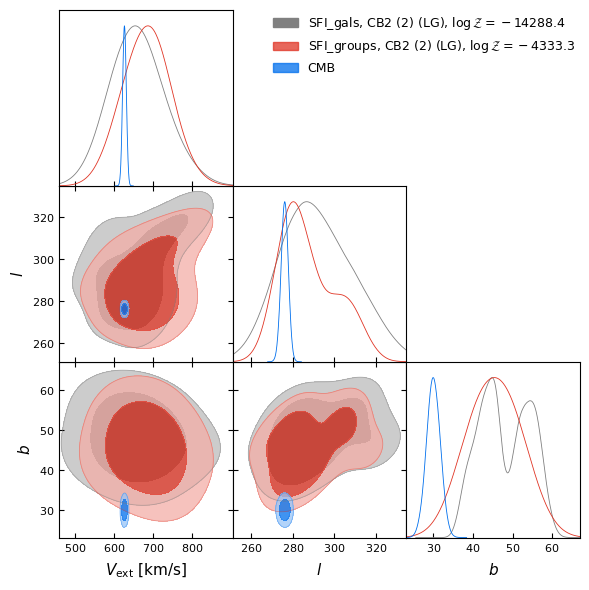

In [68]:
params = ["Vmag", "l", "b"]
CMB = MCSamples(samples=multivariate_normal([627, 276, 30], [22, 3, 3]).rvs(size=20000),
                names=params, labels=names_to_latex(params, True), label="CMB")

X = [
    # LOSS_Carrick_LG,
    # FOUNDATION_Carrick_LG,
    # PANTHEON_Carrick_LG,
    # TWOMTF_Carrick_LG,
    # SFIGAL_Carrick_LG,
    # SFIGROUPS_Carrick_LG,
    # LOSS_CB1_LG,
    # FOUNDATION_CB1_LG,
    # PANTHEON_CB1_LG,
    # TWOMTF_CB1_LG,
    # SFIGAL_CB1_LG,
    # LOSS_CB2_LG,
    # FOUNDATION_CB2_LG,
    # PANTHEON_CB2_LG,
    # TWOMTF_CB2_LG,
    SFIGAL_CB2_LG,
    SFIGROUP_CB2_LG,
    CMB,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
# g.export(f"../plots/ALL_dipole.png", dpi=500,)